<a href="https://colab.research.google.com/github/avijit-mukherjee-25/bert4rec/blob/main/DeepQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
# https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
env = gym.make("CartPole-v1")

In [4]:
# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)
print (device)

cuda


In [5]:
def plot_durations(episode_durations):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Result')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()
    return

In [6]:
# replay memory
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
      self.memory = deque([], maxlen=capacity)

    def push(self, *args):
      """Save a transition"""
      self.memory.append(Transition(*args))

    def sample(self, batch_size):
      return random.sample(self.memory, batch_size)

    def __len__(self):
      return len(self.memory)

In [7]:
class Policy(nn.Module):

    def __init__(self, env, n_observations, n_actions):
      super(Policy, self).__init__()
      self.dqn = nn.Sequential(
          nn.Linear(n_observations, 128),
          nn.ReLU(),
          nn.Linear(128, 128),
          nn.ReLU(),
          nn.Linear(128, n_actions)
      )

    def forward(self, x):
      return self.dqn(x)

    def action(self, env, state, eps):
      sample = random.random()
      if sample > eps:
          with torch.no_grad():
              return self(state).max(1).indices.view(1, 1)
      else:
          return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [8]:
class Target(nn.Module):
  def __init__(self, n_observations, n_actions):
    super(Target, self).__init__()
    self.dqn = nn.Sequential(
            nn.Linear(n_observations, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
  def forward(self, x):
    return self.dqn(x)

In [9]:
def train(memory,optimizer, policy, target, BATCH_SIZE, GAMMA):
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
          tuple(map(lambda s: s is not None,batch.next_state)),
          device=device, dtype=torch.bool
        )
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy.parameters(), 100)
    optimizer.step()
    return

Complete


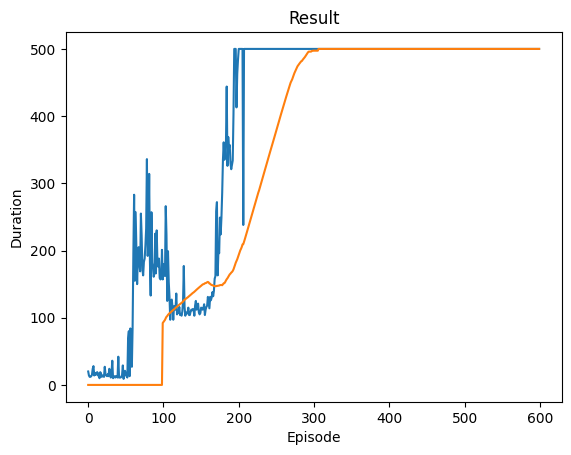

In [10]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 2500
TAU = 0.005
LR = 3e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy = Policy(env, n_observations, n_actions).to(device)
target = Target(n_observations, n_actions).to(device)
target.load_state_dict(policy.state_dict())

torch._dynamo.config.suppress_errors = True

optimizer = optim.AdamW(policy.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0
episode_durations = []

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1
        action = policy.action(env, state, eps)
        steps_done += 1
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if len(memory) > BATCH_SIZE:
          train(memory,optimizer, policy, target, BATCH_SIZE, GAMMA)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target.state_dict()
        policy_net_state_dict = policy.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            break

print('Complete')
plot_durations(episode_durations)
plt.show()